# K Means Algorithm Simple Implementation

All of you might be familiar on Kmeans algorithm especially [Kmeans on scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), so here I aim to give you a tutorial on how to implement K-means step by steps using the stanford's cs221 template code [1].


*Note: This notebook contains interactive plots, which might take sometime to be initialized. Please be patient

In [1]:
# the infamous visualzation tool
import matplotlib.pyplot as plt

# the infamous matrix operation and manipulation library
import numpy as np


# well this is new, isn't it?
# it's for making slider in jupyter notebook 
from ipywidgets import interact

In [2]:
# for debugging purpose, 
# for the impatients you does not have to care about these
import logging
import sys

log = logging.getLogger()
log.setLevel(logging.ERROR)

handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

log.addHandler(handler)

You are encouraged to read the K-means algorithm explanation on [1](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html) because I will not re-explained it here. However I will describe code implementations, which are taken from [1](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html), then converted to support more interactive features in this notebook.

I'm using code convention, as follow: 
1. function with `_[function_name]()` is for "private" function, otherwise public.
2. `log.info` is merely for debugging purpose, you should skip those when reading my codes.
3. I use `*` (asterix) for parameter passing, for shorthand. More info: [4](https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters)

In [3]:
def _get_random_centroids(num_features, k):
    """
    initializing random centroids for (
        i row -> in total matched num_features, 
        j dimension -> in total k clusters
    )
    """
    return np.array([
        [np.random.uniform() for i in range(num_features)] 
        for j in range(k)
    ])

def _should_stop(old_centroids, centroids, iterations, max_iterations):
    """
    if the algorithm should stop because it has found local maximum
    """
    if iterations >= max_iterations:
        return True
    
    if old_centroids is None:
        return False
    
    
    return (old_centroids == centroids).all()

def _get_labels(data, centroids):
    """
    get labels for every data points
    """
    labels = []
    for datum in data:
        log.info('datum: {}'.format(datum))
        log.info('centroids: {}'.format(centroids))
        
        # calculate eucledian distance between a datum and all centroids
        # say you have [1, 0] as datum, and [(1, 1), (2, 2)] as centroids
        # this code will compute [ 
        #           np.sqrt( (1 - 1) + (0 - 1) ),
        #           np.sqrt( (1 - 2) + (0 - 2) )
        # ]
        # *axis=1 means summing for every column
        dist_to_centroids = np.sqrt(
            np.power(datum - centroids, 2).sum(axis=1)
        )
        log.info('distance to centroids: {}'.format(dist_to_centroids))
        
        # finally get which index is the minimum distance centroids
        # this is become our label
        labels.append(np.argmin(dist_to_centroids))
        
    return np.array(labels)

def _get_centroids(data, labels, k):
    
    centroids = []
    for u_label_i in range(k):
        # find out which data is in cluster u_label_i
        cluster_i_elements = data[
            labels == u_label_i
        ]
        
        # if no elements in a cluster, re-initialize random centroid
        if cluster_i_elements.size == 0:
            centroids.append(
                np.random.uniform((1, data.shape[1]))
            )
            # jump into next iteration
            continue
            
        log.info('cluster {} elements: {}'.format(u_label_i, cluster_i_elements))
        
        # get the number average for each dimension in a specific
        # u_label_i cluster members
        mu_i = np.sum(cluster_i_elements, axis=0) / cluster_i_elements.shape[0]
        log.info('mu_i: {}'.format(mu_i))
        
        centroids.append(mu_i)
    
    return np.array(centroids)

def kmeans(data, k, max_iterations=30):
    # parameters initialization
    # get number of 
    num_features = data.shape[1]
    centroids = _get_random_centroids(num_features, k)
    iterations = 0
    
    old_centroids = None
    centroid_logs = [] # storing states/logs of centroids movements
    
    labels = None
    labels_logs = [] # storing states/logs of labels movements
    
    
    while not _should_stop(old_centroids, centroids, iterations, max_iterations):
        log.info('-----------------{}-----------------'.format(iterations))
        old_centroids = centroids
        
        iterations += 1
        
        labels = _get_labels(data, centroids)
        
        # store histories
        centroid_logs.append(centroids)
        labels_logs.append(labels)
        
        centroids = _get_centroids(data, labels, k)
        log.info('iteration centroids: {}'.format(centroids))
        
    return centroids, labels, centroid_logs, labels_logs

Now let's construct some dummy 2 Dimensional data. Why 2-D? because it will be easier to visualized as scatter plot.

In [4]:
data = np.array([
    [1,0],
    [1,0.5],
    [0.0,0.5],
    [2,2],
    [3,3]
])

Then visualize it on scatter plot

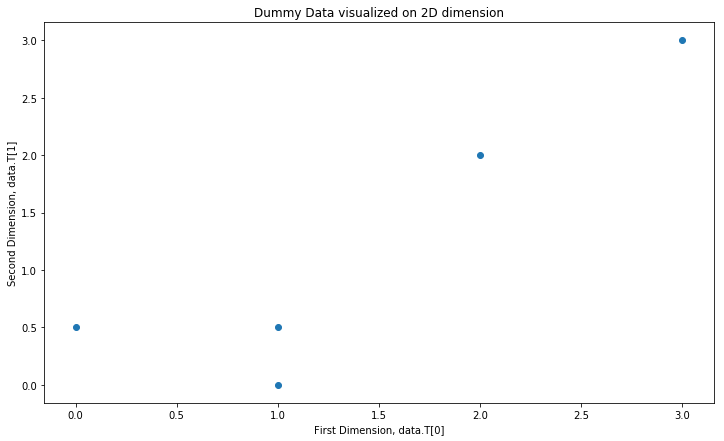

In [5]:
f, ax = plt.subplots(figsize=(12, 7))
plt.scatter(*data.T)

plt.title('Dummy Data visualized on 2D dimension')
plt.xlabel('First Dimension, data.T[0]')
plt.ylabel('Second Dimension, data.T[1]')

plt.show()

Now we run our clustering algorithm into these data.

In [6]:
# using random seed for reproducibility
np.random.seed(1)
centroids, labels, centroid_logs, label_logs = kmeans(data, 2, max_iterations=10)

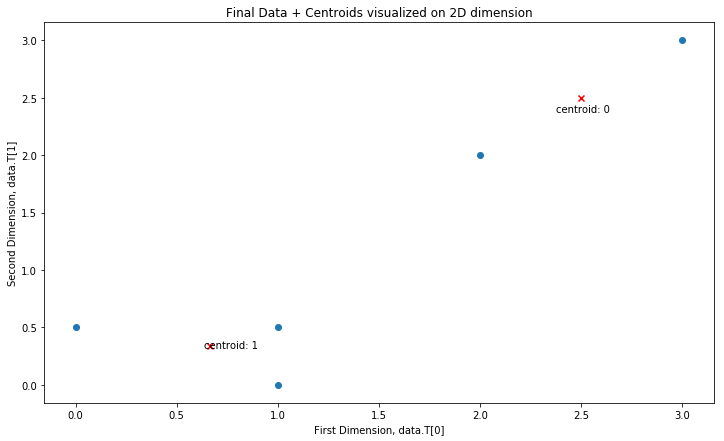

In [7]:
f, ax = plt.subplots(figsize=(12, 7))

plt.scatter(*data.T)
plt.scatter(*centroids.T, marker='x', color='red')

for label, centroid in enumerate(centroids):
    plt.annotate(
        'centroid: {}'.format(label),
        xy=centroid,
        xytext=0.95*centroid
    )

plt.title('Final Data + Centroids visualized on 2D dimension')
plt.xlabel('First Dimension, data.T[0]')
plt.ylabel('Second Dimension, data.T[1]')

plt.show()

We see that centroid 0 and centroid 1 is on the center of each clusters, as it should, by taking the means for each cluster members data. However this visualization can be improved further.

In [30]:
def draw_movements(label_logs, centroid_logs, data, centroids, labels, t):
    """
    draw data points and centroid for time t
    """
    f, ax = plt.subplots(figsize=(12, 7))
    
    labels = label_logs[t]
    centroids = centroid_logs[t]
    plt.scatter(*data.T, c=labels)
    
    for label, datum in zip(labels, data):
        plt.annotate(
            label,
            xy=datum
        )
    
    plt.scatter(*centroids.T, marker='x', color='red', label='centroid')
    
    for label, centroid in enumerate(centroids):
        plt.annotate(
            'centroid {}'.format(label), 
            xy=centroid,
            xytext=centroid * 0.75,
            arrowprops=dict(
                facecolor='black',
                arrowstyle='->',
                connectionstyle='angle3,angleA=45,angleB=-90'
            )
        )
        
    plt.title('Final Data + Centroids Movements and Cluster Members')    
    plt.xlabel('First Dimension, data.T[0]')
    plt.ylabel('Second Dimension, data.T[1]')

    plt.legend()
    plt.show()

In [31]:
def draw(t=0):
    draw_movements(
        label_logs, 
        centroid_logs,
        data,
        centroids,
        labels, 
        t
    )
interact(
    draw, 
    t=(0, len(label_logs) - 1)
)

interactive(children=(IntSlider(value=0, description='t', max=2), Output()), _dom_classes=('widget-interact',)…

<function __main__.draw(t=0)>

I have visualized how randomized centroids has been initialized at time $t=0$ and centroid 0 moved towards upper points, which finally converges at $t=2$.

This is great! Now let's see more random data points !

In [32]:
np.random.seed(1)
data_1 = np.random.rand(40, 2)
centroids_1, labels_1, centroid_logs_1, label_logs_1 = kmeans(data_1, 3, max_iterations=10)

In [33]:
def draw_1(t1=0):
    draw_movements(
        label_logs_1, 
        centroid_logs_1,
        data_1,
        centroids_1,
        labels_1, 
        t1
    )
interact(
    draw_1,
    t1=(0, len(label_logs_1) - 1)
)

interactive(children=(IntSlider(value=0, description='t1', max=5), Output()), _dom_classes=('widget-interact',…

<function __main__.draw_1(t1=0)>

Now I will use nbinteract ([2], [3]) tool to convert this notebook into interactive form! Thank you and enjoy!

# References
[1] http://stanford.edu/~cpiech/cs221/handouts/kmeans.html

[2] [Nbinteract - UC Berkeley](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2018/EECS-2018-57.pdf)

[3] [Nbinteract - Official Web](https://www.nbinteract.com/)

[4] [Stackoverflow - Asterix](https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters)